# Introduction

The U-Net model is a simple fully  convolutional neural network that is used for binary segmentation i.e foreground and background pixel-wise classification. Mainly, it consists of two parts. 

*   Contracting Path: we apply a series of conv layers and downsampling layers  (max-pooling) layers to reduce the spatial size 
*   Expanding Path: we apply a series of upsampling layers to reconstruct the spatial size of the input. 

The two parts are connected using a concatenation layers among different levels. This allows learning different features at different levels. At the end we have a simple conv 1x1 layer to reduce the number of channels to 1. 


![alt text](https://blog.playment.io/wp-content/uploads/2018/03/Screen-Shot-2018-09-05-at-3.00.03-PM.png)

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tensorflow as tf
import pandas as pd
#import keras
keras = tf.keras
Model = keras.models.Model
Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D = keras.layers.Conv2D, keras.layers.MaxPooling2D, keras.layers.Input, keras.layers.Conv2DTranspose, keras.layers.Concatenate, keras.layers.BatchNormalization, keras.layers.UpSampling2D
Dropout, Activation = keras.layers.Dropout, keras.layers.Activation
Adam, SGD = keras.optimizers.Adam, keras.optimizers.SGD
ModelCheckpoint, ReduceLROnPlateau, EarlyStopping = keras.callbacks.ModelCheckpoint, keras.callbacks. ReduceLROnPlateau, keras.callbacks.EarlyStopping
K = keras.backend
plot_model = keras.utils.plot_model

import glob
import random
import cv2
from random import shuffle

# Dataset

We will use the The Oxford-IIIT Pet Dataset. It contains 37 classes of dogs and cats with around 200 images per each class. The dataset contains labels as bounding boxes and segmentation masks. The total number of images in the dataset is a little more than 7K. 

![alt text](http://www.robots.ox.ac.uk/~vgg/data/pets/pet_annotations.jpg)

Download the images/masks and unzip the files 

In [3]:
t = Image.open("binary/0.png")
i = np.array(t)
i = i[:,:,0]
i.shape

(501, 501)

Note that we have two foulders. The first one is `images` which contains the raw images and annotation which contains the masks as a `binary` foulder image.

# Generators

In [4]:
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:

        #get the masks. Note that masks are png files 
        mask = Image.open(f'roots/{f}.png')
        mask = np.array(mask.resize(sz))


        #preprocess the mask 
        mask[mask == 0] = 0 
        mask[mask != 0 ] = 1
        
        batch_y.append(mask)

        #preprocess the raw images 
        raw = Image.open(f'original/{f}.png')
        raw = raw.resize(sz)
        raw = np.array(raw)

        #check the number of channels because some of the images are RGBA or GRAY
        if len(raw.shape) == 2:
          raw = np.stack((raw,)*3, axis=-1)

        else:
          raw = raw[:,:,0:3]

        batch_x.append(raw)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
    batch_y = np.stack((batch_y,)*3, axis=-1)
    #batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      
    

In [5]:
batch_size = 32

all_files = [i for i in range(4049)]
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [6]:
x, y= next(train_generator)

In [7]:
y.shape

(32, 256, 256, 3)

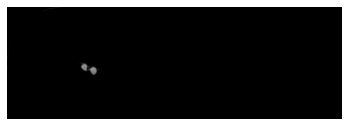

In [8]:
plt.axis('off')
img = x[0]
msk = y[0].squeeze()
#msk = np.stack((msk,)*3, axis=-1)

plt.imshow( np.concatenate([img, msk, img*msk], axis = 1))

# IoU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. Given two masks $y_{true}, y_{pred}$ we evaluate 

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [9]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

# Model

In [10]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [11]:
model = unet()

# Callbacks

Simple functions to save the model at each epoch and show some predictions 

In [12]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        #choose a random test image and preprocess
        path = np.random.choice(test_files)
        raw = Image.open(f'original/{path}.png')
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        
        truemsk = Image.open(f'roots/{path}.png')
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        truemsk = np.stack((truemsk,)*3, axis=-1)
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))
        
        #mask post-processing 
        msk  = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        #show the mask and the segmented image 
        combined = np.concatenate([raw, msk, truemsk, raw* msk], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

# Training

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 6 steps
Epoch 1/30
119/120 [============================>.] - ETA: 3s - loss: 0.0022 - mean_iou: 0.3523i= 1 loss= 0.0021582357013054812 val_loss= 0.001347079504436503 mean_iou= 0.3551193 val_mean_iou= 0.54685205


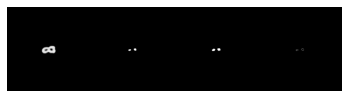

120/120 [==============================] - 378s 3s/step - loss: 0.0022 - mean_iou: 0.3551 - val_loss: 0.0013 - val_mean_iou: 0.5469
Epoch 2/30
119/120 [============================>.] - ETA: 3s - loss: 0.0016 - mean_iou: 0.5975i= 2 loss= 0.0016155402054816173 val_loss= 0.0013704815258582432 mean_iou= 0.59686506 val_mean_iou= 0.68343204


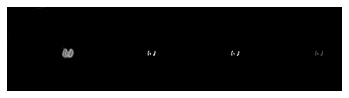

120/120 [==============================] - 379s 3s/step - loss: 0.0016 - mean_iou: 0.5969 - val_loss: 0.0014 - val_mean_iou: 0.6834
Epoch 3/30
119/120 [============================>.] - ETA: 3s - loss: 0.0013 - mean_iou: 0.6502i= 3 loss= 0.001346989816132312 val_loss= 0.0015673539601266384 mean_iou= 0.6505226 val_mean_iou= 0.6686592


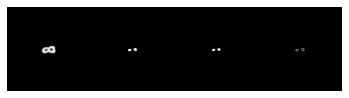

120/120 [==============================] - 388s 3s/step - loss: 0.0013 - mean_iou: 0.6505 - val_loss: 0.0016 - val_mean_iou: 0.6687
Epoch 4/30
119/120 [============================>.] - ETA: 3s - loss: 0.0012 - mean_iou: 0.6920i= 4 loss= 0.0012060042407635288 val_loss= 0.001070542901288718 mean_iou= 0.69282174 val_mean_iou= 0.7392428


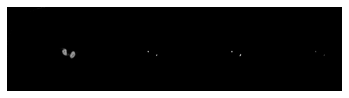

120/120 [==============================] - 400s 3s/step - loss: 0.0012 - mean_iou: 0.6928 - val_loss: 0.0011 - val_mean_iou: 0.7392
Epoch 5/30
119/120 [============================>.] - ETA: 3s - loss: 0.0011 - mean_iou: 0.7135i= 5 loss= 0.0010927156419105208 val_loss= 0.0011993750037314992 mean_iou= 0.71420115 val_mean_iou= 0.6685989


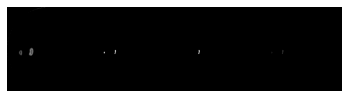

120/120 [==============================] - 387s 3s/step - loss: 0.0011 - mean_iou: 0.7142 - val_loss: 0.0012 - val_mean_iou: 0.6686
Epoch 6/30
119/120 [============================>.] - ETA: 3s - loss: 0.0010 - mean_iou: 0.7152i= 6 loss= 0.0010149233106252116 val_loss= 0.0008686072639344881 mean_iou= 0.7146466 val_mean_iou= 0.7653902


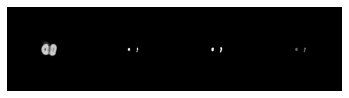

120/120 [==============================] - 384s 3s/step - loss: 0.0010 - mean_iou: 0.7146 - val_loss: 8.6861e-04 - val_mean_iou: 0.7654
Epoch 7/30
119/120 [============================>.] - ETA: 3s - loss: 9.0239e-04 - mean_iou: 0.7431i= 7 loss= 0.0009021280469217648 val_loss= 0.0008697595136861006 mean_iou= 0.7428755 val_mean_iou= 0.74790674


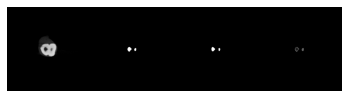

120/120 [==============================] - 377s 3s/step - loss: 9.0213e-04 - mean_iou: 0.7429 - val_loss: 8.6976e-04 - val_mean_iou: 0.7479
Epoch 8/30
119/120 [============================>.] - ETA: 3s - loss: 9.1885e-04 - mean_iou: 0.7445i= 8 loss= 0.0009172623133054004 val_loss= 0.0007818215623653183 mean_iou= 0.7449283 val_mean_iou= 0.779933


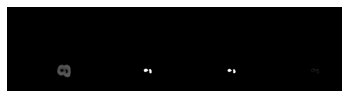

120/120 [==============================] - 377s 3s/step - loss: 9.1726e-04 - mean_iou: 0.7449 - val_loss: 7.8182e-04 - val_mean_iou: 0.7799
Epoch 9/30
119/120 [============================>.] - ETA: 3s - loss: 8.4050e-04 - mean_iou: 0.7589i= 9 loss= 0.0008381717804392489 val_loss= 0.0007848434324841946 mean_iou= 0.7594081 val_mean_iou= 0.77776784


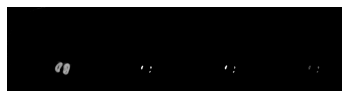

120/120 [==============================] - 384s 3s/step - loss: 8.3817e-04 - mean_iou: 0.7594 - val_loss: 7.8484e-04 - val_mean_iou: 0.7778
Epoch 10/30
119/120 [============================>.] - ETA: 3s - loss: 7.9767e-04 - mean_iou: 0.7666i= 10 loss= 0.000797472219953003 val_loss= 0.000814141375788798 mean_iou= 0.7668125 val_mean_iou= 0.7553076


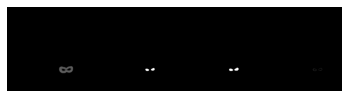

120/120 [==============================] - 405s 3s/step - loss: 7.9747e-04 - mean_iou: 0.7668 - val_loss: 8.1414e-04 - val_mean_iou: 0.7553
Epoch 11/30
119/120 [============================>.] - ETA: 3s - loss: 7.4576e-04 - mean_iou: 0.7817i= 11 loss= 0.0007442136654087032 val_loss= 0.0007587285460128138 mean_iou= 0.78205025 val_mean_iou= 0.78333235


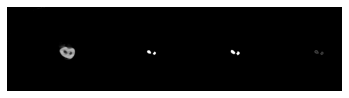

120/120 [==============================] - 439s 4s/step - loss: 7.4421e-04 - mean_iou: 0.7821 - val_loss: 7.5873e-04 - val_mean_iou: 0.7833
Epoch 12/30
119/120 [============================>.] - ETA: 3s - loss: 6.9583e-04 - mean_iou: 0.7904i= 12 loss= 0.0006946431019362838 val_loss= 0.0006293827415599177 mean_iou= 0.79034734 val_mean_iou= 0.81589085


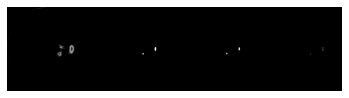

120/120 [==============================] - 419s 3s/step - loss: 6.9464e-04 - mean_iou: 0.7903 - val_loss: 6.2938e-04 - val_mean_iou: 0.8159
Epoch 13/30
119/120 [============================>.] - ETA: 3s - loss: 6.5771e-04 - mean_iou: 0.7988i= 13 loss= 0.0006567428950802423 val_loss= 0.0006887071649543941 mean_iou= 0.7989176 val_mean_iou= 0.8043246


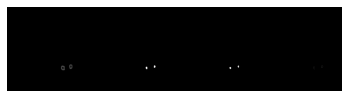

120/120 [==============================] - 408s 3s/step - loss: 6.5674e-04 - mean_iou: 0.7989 - val_loss: 6.8871e-04 - val_mean_iou: 0.8043
Epoch 14/30
119/120 [============================>.] - ETA: 3s - loss: 6.2625e-04 - mean_iou: 0.8088i= 14 loss= 0.0006254727552004625 val_loss= 0.0005594841786660254 mean_iou= 0.8089817 val_mean_iou= 0.8391859


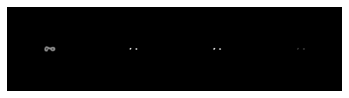

120/120 [==============================] - 398s 3s/step - loss: 6.2547e-04 - mean_iou: 0.8090 - val_loss: 5.5948e-04 - val_mean_iou: 0.8392
Epoch 15/30
119/120 [============================>.] - ETA: 3s - loss: 6.1980e-04 - mean_iou: 0.8162i= 15 loss= 0.0006215734147796563 val_loss= 0.0007336281899673244 mean_iou= 0.81617826 val_mean_iou= 0.81652546


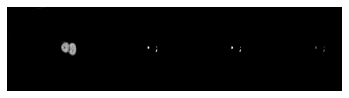

120/120 [==============================] - 407s 3s/step - loss: 6.2157e-04 - mean_iou: 0.8162 - val_loss: 7.3363e-04 - val_mean_iou: 0.8165
Epoch 16/30
119/120 [============================>.] - ETA: 3s - loss: 5.8580e-04 - mean_iou: 0.8218i= 16 loss= 0.0005851696737712094 val_loss= 0.0006664492733155688 mean_iou= 0.8218594 val_mean_iou= 0.8194318


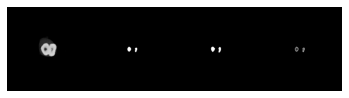

120/120 [==============================] - 399s 3s/step - loss: 5.8517e-04 - mean_iou: 0.8219 - val_loss: 6.6645e-04 - val_mean_iou: 0.8194
Epoch 17/30
119/120 [============================>.] - ETA: 3s - loss: 5.6786e-04 - mean_iou: 0.8187i= 17 loss= 0.0005669069874177997 val_loss= 0.0005513901511828104 mean_iou= 0.81917375 val_mean_iou= 0.8239481


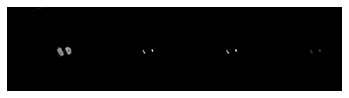

120/120 [==============================] - 397s 3s/step - loss: 5.6691e-04 - mean_iou: 0.8192 - val_loss: 5.5139e-04 - val_mean_iou: 0.8239
Epoch 18/30
119/120 [============================>.] - ETA: 3s - loss: 5.9613e-04 - mean_iou: 0.8244i= 18 loss= 0.0005946726298134309 val_loss= 0.0005931753112236038 mean_iou= 0.82463926 val_mean_iou= 0.83435243


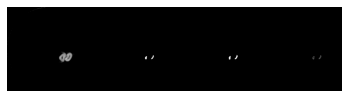

120/120 [==============================] - 399s 3s/step - loss: 5.9467e-04 - mean_iou: 0.8246 - val_loss: 5.9318e-04 - val_mean_iou: 0.8344
Epoch 19/30
119/120 [============================>.] - ETA: 3s - loss: 5.3269e-04 - mean_iou: 0.8331i= 19 loss= 0.0005325785270542838 val_loss= 0.0006059433508198708 mean_iou= 0.8329798 val_mean_iou= 0.8278768


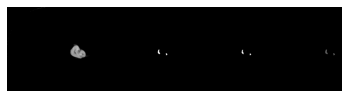

120/120 [==============================] - 398s 3s/step - loss: 5.3258e-04 - mean_iou: 0.8330 - val_loss: 6.0594e-04 - val_mean_iou: 0.8279
Epoch 20/30
119/120 [============================>.] - ETA: 3s - loss: 5.2730e-04 - mean_iou: 0.8363i= 20 loss= 0.0005262729867051045 val_loss= 0.0006021997978677973 mean_iou= 0.836574 val_mean_iou= 0.8448227


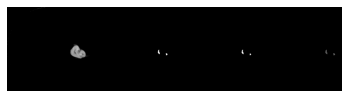

120/120 [==============================] - 398s 3s/step - loss: 5.2627e-04 - mean_iou: 0.8366 - val_loss: 6.0220e-04 - val_mean_iou: 0.8448
Epoch 21/30
119/120 [============================>.] - ETA: 3s - loss: 5.0656e-04 - mean_iou: 0.8415i= 21 loss= 0.0005067860385073194 val_loss= 0.0005636120913550258 mean_iou= 0.84156543 val_mean_iou= 0.8402799


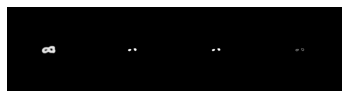

120/120 [==============================] - 397s 3s/step - loss: 5.0679e-04 - mean_iou: 0.8416 - val_loss: 5.6361e-04 - val_mean_iou: 0.8403
Epoch 22/30
119/120 [============================>.] - ETA: 3s - loss: 4.9504e-04 - mean_iou: 0.8478i= 22 loss= 0.0004934726292655493 val_loss= 0.0004768960546546926 mean_iou= 0.84802276 val_mean_iou= 0.8629536


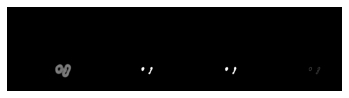

120/120 [==============================] - 395s 3s/step - loss: 4.9347e-04 - mean_iou: 0.8480 - val_loss: 4.7690e-04 - val_mean_iou: 0.8630
Epoch 23/30
119/120 [============================>.] - ETA: 3s - loss: 4.6605e-04 - mean_iou: 0.8521i= 23 loss= 0.0004653671281024193 val_loss= 0.0004929466861843442 mean_iou= 0.8522087 val_mean_iou= 0.85005254


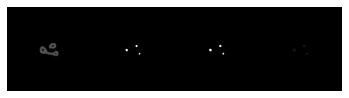

120/120 [==============================] - 396s 3s/step - loss: 4.6537e-04 - mean_iou: 0.8522 - val_loss: 4.9295e-04 - val_mean_iou: 0.8501
Epoch 24/30
119/120 [============================>.] - ETA: 3s - loss: 4.8290e-04 - mean_iou: 0.8488i= 24 loss= 0.0004819643004642179 val_loss= 0.0005901694288089251 mean_iou= 0.849044 val_mean_iou= 0.84785146


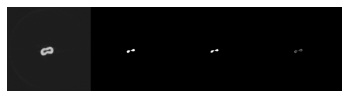

120/120 [==============================] - 395s 3s/step - loss: 4.8196e-04 - mean_iou: 0.8490 - val_loss: 5.9017e-04 - val_mean_iou: 0.8479
Epoch 25/30
119/120 [============================>.] - ETA: 3s - loss: 4.7393e-04 - mean_iou: 0.8529i= 25 loss= 0.0004724125436041504 val_loss= 0.0006044786423444748 mean_iou= 0.8531651 val_mean_iou= 0.85559803


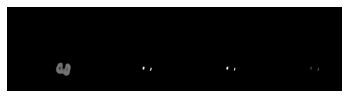

120/120 [==============================] - 397s 3s/step - loss: 4.7241e-04 - mean_iou: 0.8532 - val_loss: 6.0448e-04 - val_mean_iou: 0.8556
Epoch 26/30
119/120 [============================>.] - ETA: 3s - loss: 4.7416e-04 - mean_iou: 0.8532i= 26 loss= 0.00047363471191298837 val_loss= 0.0004815900222941612 mean_iou= 0.8531782 val_mean_iou= 0.8638602


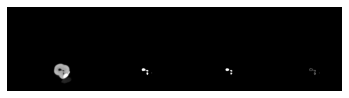

120/120 [==============================] - 417s 3s/step - loss: 4.7363e-04 - mean_iou: 0.8532 - val_loss: 4.8159e-04 - val_mean_iou: 0.8639
Epoch 27/30
119/120 [============================>.] - ETA: 3s - loss: 4.4351e-04 - mean_iou: 0.8628i= 27 loss= 0.0004441443799199381 val_loss= 0.0004608018595414857 mean_iou= 0.86245245 val_mean_iou= 0.8490855


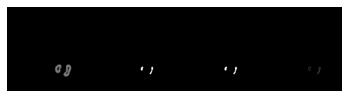

120/120 [==============================] - 398s 3s/step - loss: 4.4414e-04 - mean_iou: 0.8625 - val_loss: 4.6080e-04 - val_mean_iou: 0.8491
Epoch 28/30
119/120 [============================>.] - ETA: 3s - loss: 4.1970e-04 - mean_iou: 0.8641i= 28 loss= 0.0004194010483236828 val_loss= 0.0005220320890657604 mean_iou= 0.8640353 val_mean_iou= 0.84235376


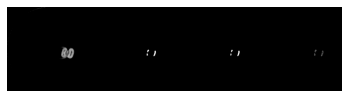

120/120 [==============================] - 393s 3s/step - loss: 4.1940e-04 - mean_iou: 0.8640 - val_loss: 5.2203e-04 - val_mean_iou: 0.8424
Epoch 29/30
119/120 [============================>.] - ETA: 3s - loss: 4.2271e-04 - mean_iou: 0.8641i= 29 loss= 0.0004228417987178545 val_loss= 0.0004621550178853795 mean_iou= 0.86397 val_mean_iou= 0.8537043


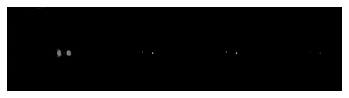

120/120 [==============================] - 394s 3s/step - loss: 4.2284e-04 - mean_iou: 0.8640 - val_loss: 4.6216e-04 - val_mean_iou: 0.8537
Epoch 30/30
119/120 [============================>.] - ETA: 3s - loss: 4.2988e-04 - mean_iou: 0.8637i= 30 loss= 0.0004317449131728305 val_loss= 0.0006031864662266647 mean_iou= 0.86352295 val_mean_iou= 0.8159411


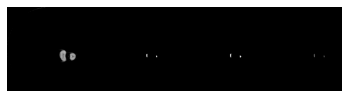

120/120 [==============================] - 396s 3s/step - loss: 4.3174e-04 - mean_iou: 0.8635 - val_loss: 6.0319e-04 - val_mean_iou: 0.8159


In [15]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                    callbacks = build_callbacks(), verbose = 1)

# Loading

In [13]:
model.load_weights("unet.h5")

In [14]:
from scipy.spatial.distance import directed_hausdorff
from tqdm.notebook import tqdm, trange

def vecHausdorff(Y, P):
    dist = []
    for i in range(Y.shape[0]):
        o = directed_hausdorff(Y[i], P[i])[0]
        v = directed_hausdorff(P[i], Y[i])[0]
        dist.append(max(o,v))
        
    return np.array(dist)
        

def pairwise_iou(y_true, y_pred):
    yt0 = y_true
    yp0 = y_pred
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)), axis=(1,2))
    union = tf.math.count_nonzero(tf.add(yt0, yp0), axis=(1,2))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou.numpy()

def calcMetricsForImges(Y, P):
    # X is array of images in RGB
    # Y is array of masks in GRAY and Binarised
    # P is the predicted mask in GRAY and Binarised
    iou = pairwise_iou(Y, P) # IOU, aka. Jaccard index
    dice = (2*iou) / (iou + np.ones(iou.shape)) # Dice Coeff
    hdorf = vecHausdorff(Y, P)
    maskintenseity = np.count_nonzero(Y, axis=(1,2))
    predintensity = np.count_nonzero(P, axis=(1,2))
    return np.array([iou, dice, hdorf, maskintenseity, predintensity])

def processImages(r):
    
    imgPaths = [f"original/{i}.png" for i in r]
    mskPaths = [f"roots/{i}.png" for i in r]
    
    outs = []
    
    for i in range(len(r)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        metrics = calcMetricsForImges(np.array([truemsk,]), np.array([msk,]))
        print(f"IOU: {metrics[0,0]}")
        
        diff = truemsk != msk
        diff = diff.astype(np.float)
        
        truemsk = np.stack((truemsk,)*3, axis=-1)
        msk = np.stack((msk,)*3, axis=-1)
        diff = np.stack((diff,)*3, axis=-1)
        #show the mask and the segmented image 
        
        combined = np.concatenate([raw, msk, truemsk, diff], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

IOU: 0.27397260069847107


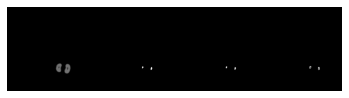

IOU: 0.40776699781417847


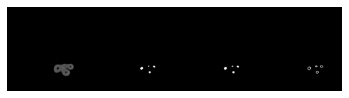

IOU: 0.5179855823516846


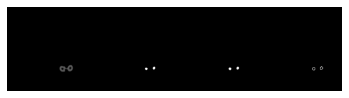

IOU: 0.35374149680137634


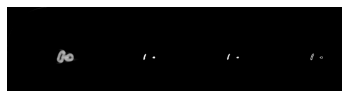

In [14]:
res = processImages([500, 1000, 1500, 3000])

In [15]:
res[0].shape

TypeError: 'NoneType' object is not subscriptable

# Testing and Validating

In [15]:
arr = pairwise_iou(np.array([img,msk]), np.array([msk,msk]))
directed_hausdorff(msk[:,0], msk[:,0])

(0.0, 158, 247)

In [16]:


def validateTrainImages(model, r):
    imgPaths = [f"original/{i}.png" for i in r]
    mskPaths = [f"roots/{i}.png" for i in r]
    
    
    masks = []
    preds = []
    for i in trange(len(imgPaths)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        truemsk[truemsk >= 0.5] = 1 
        truemsk[truemsk < 0.5] = 0
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        masks.append(truemsk)
        preds.append(msk)
    
    metrics = calcMetricsForImges(np.array(masks), np.array(preds))
    metricsDF = pd.DataFrame(data=metrics.T, columns=["iou", "dice", "hdorf", "mask_intensity", "pred_intensity"])
    return metricsDF
    
    
    

In [17]:
metrics = validateTrainImages(model, range(4049))

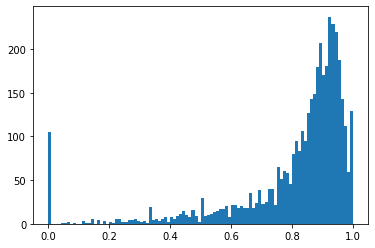

In [31]:
pieces, ranges, pl = plt.hist(metrics["iou"], bins=100)
# Az IOU eloszlása
# X tengely: IOU
# Y tengely: Abszolút előfordulás

In [32]:
np.insert(np.cumsum(pieces), 0, 0.0)

array([   0.,  105.,  105.,  105.,  105.,  106.,  107.,  109.,  109.,
        110.,  110.,  110.,  113.,  114.,  115.,  120.,  120.,  124.,
        124.,  127.,  127.,  129.,  130.,  135.,  140.,  142.,  144.,
        148.,  152.,  158.,  161.,  163.,  166.,  167.,  186.,  190.,
        196.,  199.,  204.,  212.,  214.,  222.,  227.,  236.,  247.,
        262.,  272.,  280.,  296.,  305.,  307.,  337.,  346.,  356.,
        367.,  380.,  395.,  412.,  429.,  449.,  457.,  478.,  499.,
        517.,  537.,  555.,  573.,  608.,  626.,  650.,  689.,  712.,
        737.,  777.,  817.,  838.,  903.,  954., 1014., 1072., 1117.,
       1197., 1292., 1375., 1481., 1576., 1703., 1846., 1994., 2174.,
       2381., 2551., 2732., 2969., 3198., 3418., 3606., 3749., 3861.,
       3920., 4049.])

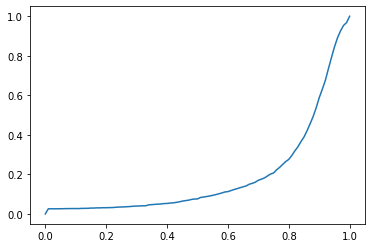

In [33]:
plt.plot(ranges, np.insert(np.cumsum(pieces), 0, 0.0) / np.cumsum(pieces)[-1])
# Az IOU kumulatív eloszlása
# X tengely: IOU
# Y tengely: kumulatív eloszlás

In [34]:
metrics["iou"]

0       0.882114
1       0.898058
2       0.913265
3       0.890805
4       0.905109
          ...   
4044    0.457143
4045    0.410256
4046    0.526316
4047    0.388889
4048    0.461538
Name: iou, Length: 4049, dtype: float64

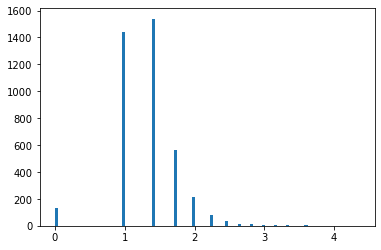

In [23]:
pieces, ranges, pl = plt.hist(metrics["hdorf"], bins=100)
# Huasdorf távolságok eloszlása

In [35]:
np.where(metrics["iou"] <= 0.01)

(array([  75,   76,  171,  174,  175,  274,  275,  276,  372,  373,  374,
         375,  453,  541,  673,  774,  972,  974,  975,  976, 1071, 1152,
        1215, 1216, 1217, 1271, 1273, 1276, 1277, 1278, 1279, 1280, 1281,
        1283, 1657, 1658, 1702, 1727, 1799, 1823, 1906, 1907, 1909, 2007,
        2111, 2204, 2205, 2206, 2207, 2307, 2308, 2356, 2357, 2359, 2360,
        2361, 2437, 2438, 2440, 2441, 2442, 2443, 2565, 2566, 2614, 2615,
        2616, 2690, 2691, 2692, 2693, 2755, 2841, 2914, 2917, 3057, 3058,
        3130, 3131, 3132, 3213, 3218, 3219, 3220, 3223, 3298, 3454, 3613,
        3614, 3615, 3616, 3617, 3622, 3759, 3761, 3762, 3763, 3834, 3879,
        3880, 3957, 3960, 3961, 3962, 3966], dtype=int64),)

In [36]:
selected_tests = np.array([
    [6,57,185,455,601,619,729,825,986,1658],
    [1670,1732,1866,2443,3303],
    [75,171,373,1278,3298]
])

In [18]:
indexDF = pd.read_csv("ids.csv")

In [19]:
mxslices = indexDF.groupby("DID").agg({"slice" : [np.min, np.max]})
mxslices

slice     
     amin amax
DID           
0     253  329
1     136  234
2     145  247
3     152  249
4     150  226
5     146  233
6     178  236
7     153  246
8     169  251
9     177  270
10    147  253
11    159  253
12    137  215
13    150  214
14    156  223
15    168  251
16    173  274
17    170  263
18    159  251
19    143  241
20    161  235
21    249  335
22    285  374
23    272  374
24    259  353
25    269  371
26    272  322
27    281  366
28    272  361
29    270  352
30    276  347
31    224  286
32    288  374
33    279  353
34    262  336
35    297  363
36    272  344
37    237  326
38    228  303
39    271  333
40    281  372
41    283  370
42    237  321
43    267  343
44    246  305
45    269  339
46    292  344
47    234  315
48    235  313

In [20]:
merged = pd.merge(indexDF, mxslices, on="DID").drop(columns="Unnamed: 0")
merged["pos"] = (merged["slice"] - merged["slice", "amin"]) / (merged["slice", "amax"] - merged["slice", "amin"])
merged = merged.drop(columns=[["slice", "amax"], ["slice", "amin"]])
merged

C:\Users\szabo\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,GID,directory,slice,DID,pos
0,0,C:\Users\szabo\Documents\fogak\CBCT 14d_100,253,0,0.000000
1,1,C:\Users\szabo\Documents\fogak\CBCT 14d_100,254,0,0.013158
2,2,C:\Users\szabo\Documents\fogak\CBCT 14d_100,255,0,0.026316
3,3,C:\Users\szabo\Documents\fogak\CBCT 14d_100,256,0,0.039474
4,4,C:\Users\szabo\Documents\fogak\CBCT 14d_100,257,0,0.052632
...,...,...,...,...,...
4044,4044,C:\Users\szabo\Documents\fogak\CBCT 7d_100,309,48,0.948718
4045,4045,C:\Users\szabo\Documents\fogak\CBCT 7d_100,310,48,0.961538
4046,4046,C:\Users\szabo\Documents\fogak\CBCT 7d_100,311,48,0.974359
4047,4047,C:\Users\szabo\Documents\fogak\CBCT 7d_100,312,48,0.987179


In [21]:
combined = pd.merge(merged, metrics, left_index=True, right_index=True)
combined

,GID,directory,slice,DID,pos,iou,dice,hdorf,mask_intensity,pred_intensity
0,0,C:\Users\szabo\Documents\fogak\CBCT 14d_100,253,0,0.000000,0.863281,0.926625,2.000000,237.0,240.0
1,1,C:\Users\szabo\Documents\fogak\CBCT 14d_100,254,0,0.013158,0.895735,0.945000,2.000000,192.0,208.0
2,2,C:\Users\szabo\Documents\fogak\CBCT 14d_100,255,0,0.026316,0.883495,0.938144,1.414214,206.0,182.0
3,3,C:\Users\szabo\Documents\fogak\CBCT 14d_100,256,0,0.039474,0.868852,0.929825,1.414214,181.0,161.0
4,4,C:\Users\szabo\Documents\fogak\CBCT 14d_100,257,0,0.052632,0.895833,0.945055,1.414214,143.0,130.0
...,...,...,...,...,...,...,...,...,...,...
4044,4044,C:\Users\szabo\Documents\fogak\CBCT 7d_100,309,48,0.948718,0.486486,0.654545,2.000000,34.0,21.0
4045,4045,C:\Users\szabo\Documents\fogak\CBCT 7d_100,310,48,0.961538,0.400000,0.571429,2.236068,40.0,16.0
4046,4046,C:\Users\szabo\Documents\fogak\CBCT 7d_100,311,48,0.974359,0.409091,0.580645,2.000000,16.0,15.0
4047,4047,C:\Users\szabo\Documents\fogak\CBCT 7d_100,312,48,0.987179,0.333333,0.500000,1.732051,15.0,9.0


In [22]:
combined.to_csv("metrics.csv")

In [2]:
# Load saved metrics
combined = pd.read_csv("metrics.csv")

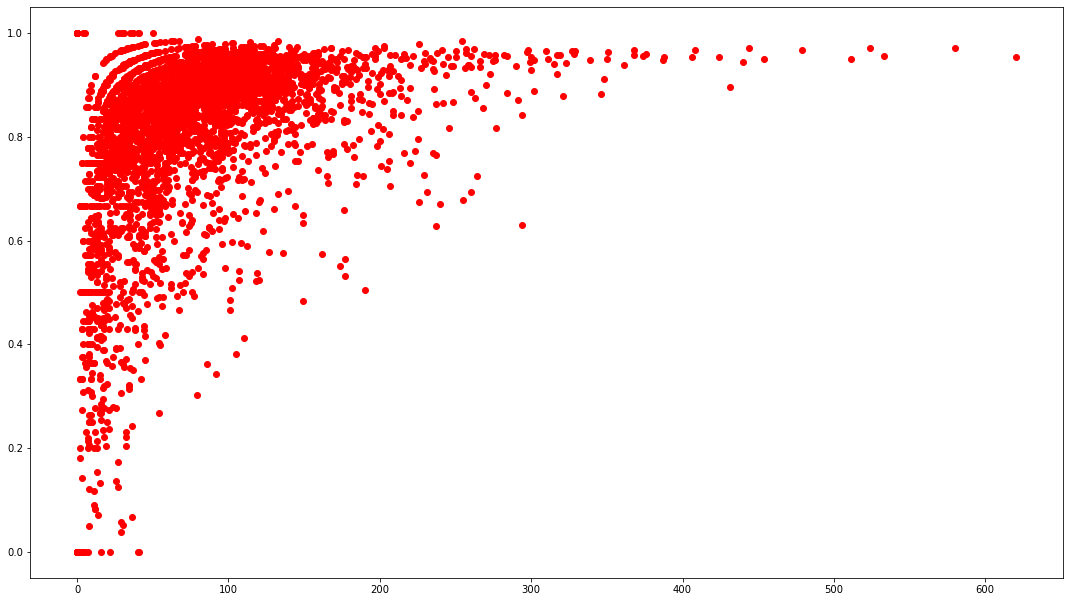

In [3]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(combined.mask_intensity, combined.iou, "ro")
# IOU eloszlása a maszk fehér pixeleniek függvényében
# X tengely: A maszk fehér pixeleinek száma
# Y tengely: IOU

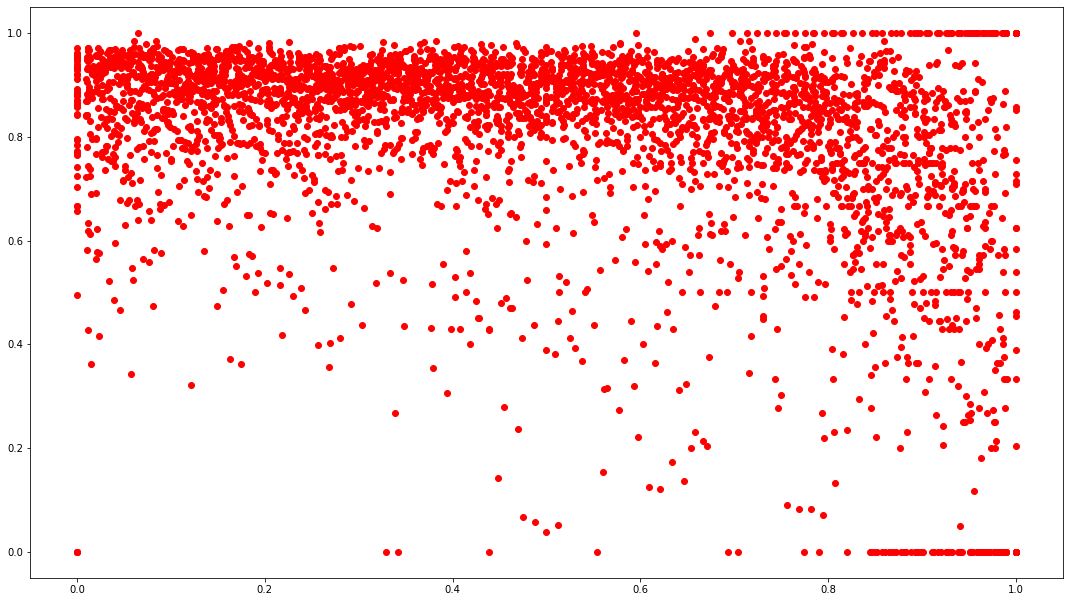

In [4]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(combined.pos, combined.iou, "ro")
# IOU eloszlása a szelet fogbeli elhelyezkedése alapján
# X tengely: A szelet fogbeli helye, ahol 0 az első szelet, amihez tartozik maszk és 1 az utolsó
# Y tengely: IOU

(-31.0, 651.0)

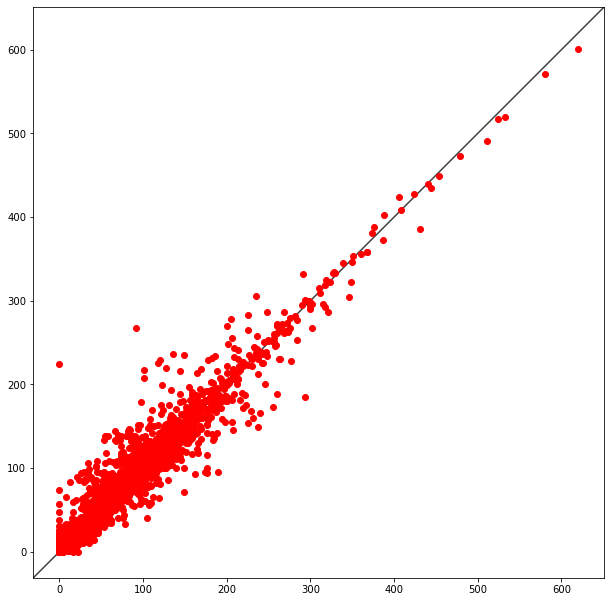

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)

ax.plot(combined.mask_intensity, combined.pred_intensity, "ro")
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

# Az elvárt és a kimeneti maszk fehér pixeleinek eloszlása
# X tengely: Az elvárt maszk fehér pixeleinek száma
# Y tengely: A kimeneti maszk fehér pixeleinek száma

In [7]:
histData2D = np.histogram2d(combined.mask_intensity, combined.pred_intensity, bins=(100,100))

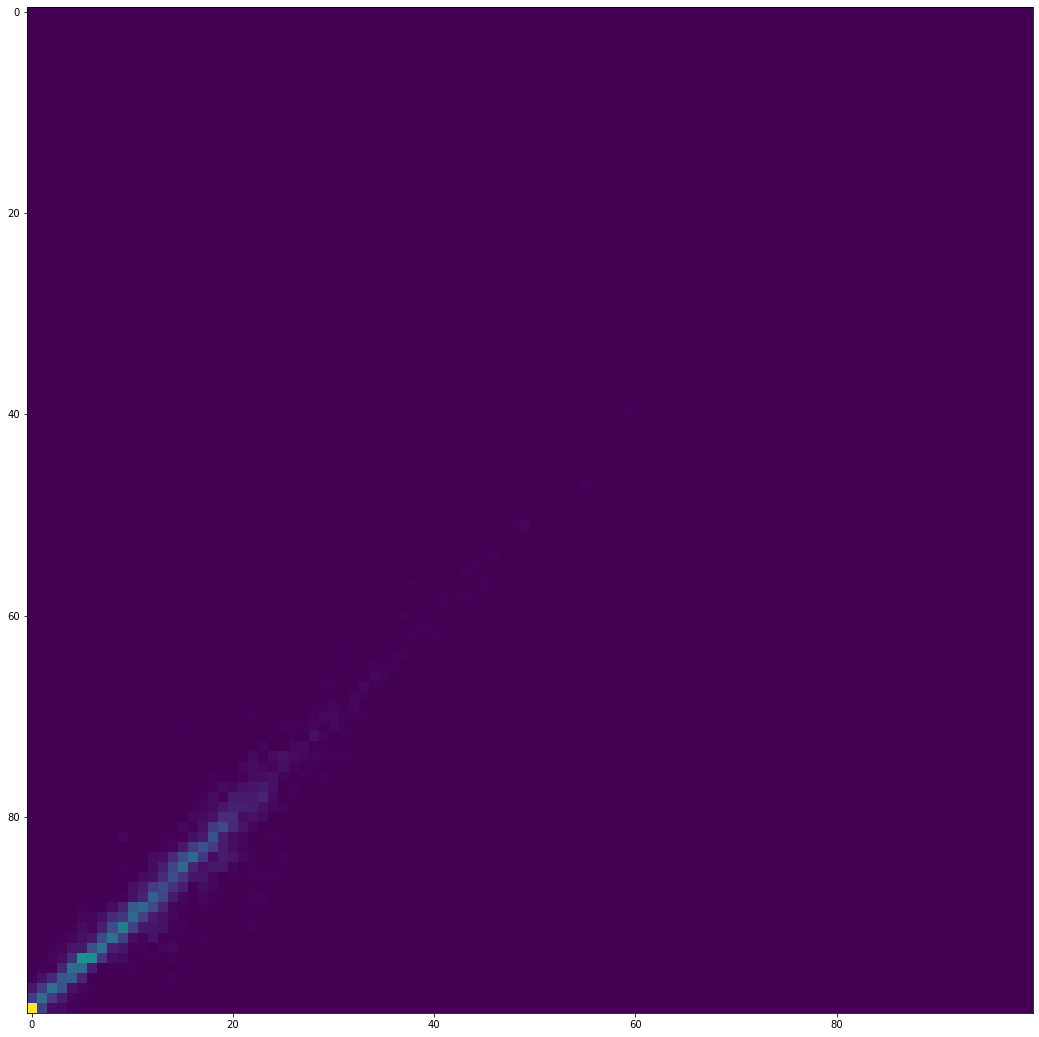

In [13]:
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plt.imshow(histData2D[0][::-1, :])

In [18]:
barData = combined[combined.iou < 0.1].groupby("DID").count() / combined.groupby("DID").count()

In [20]:
np.

<module 'pandas' from 'C:\\Users\\szabo\\Anaconda3\\lib\\site-packages\\pandas\\__init__.py'>

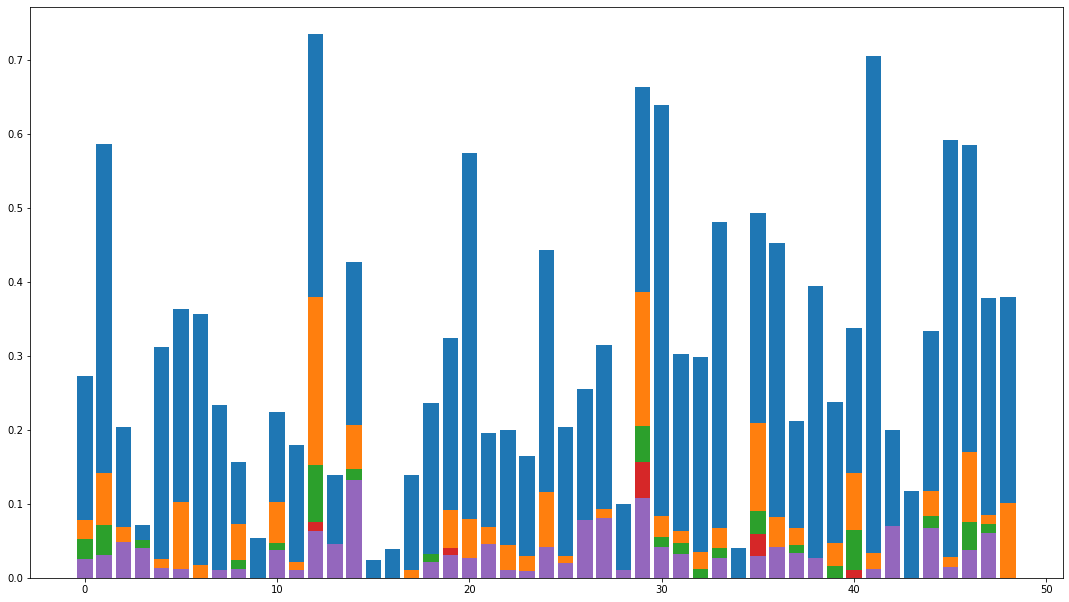

In [19]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
for limit in reversed([0.1, 0.2, 0.3, 0.5, 0.8]):
    barData = combined[combined.iou < limit].groupby("DID").count() / combined.groupby("DID").count()
    plt.bar(barData.index.values, barData.iou.values);
plt.show()

# Histogram a hibák relatív számának alakulásáról feogak szerint
# X tengely: a fog azonosítója
# Y tengely: A hibák relatív száma, ahol hibának vesszük a:
# lila: 0.1, piros : 0.2, zöld : 0.3, sárga : 0.5, kék : 0.8
# alatti IOU-val rendelkező képeket.

IOU: 0.0


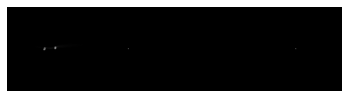

IOU: 0.0


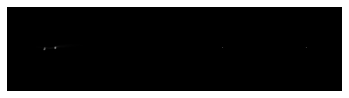

IOU: 0.0


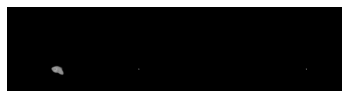

IOU: 0.0


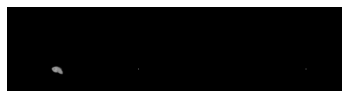

IOU: 0.0


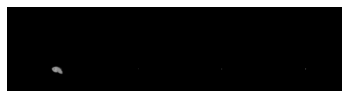

IOU: 0.04545454680919647


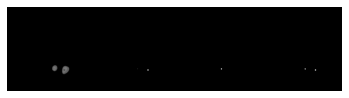

IOU: 0.0555555559694767


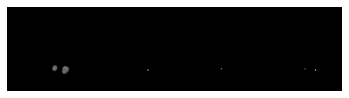

IOU: 0.0


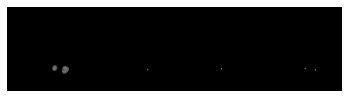

IOU: 0.0


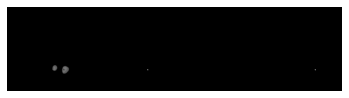

IOU: 0.0


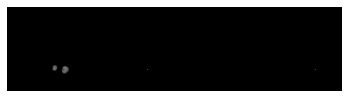

IOU: 0.0


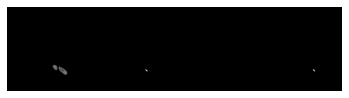

IOU: 0.0


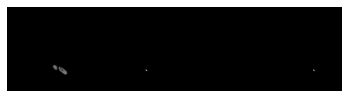

IOU: 0.0


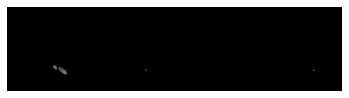

IOU: 0.0


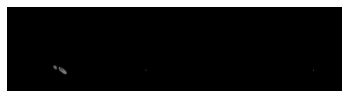

IOU: 0.0


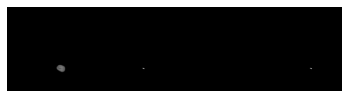

IOU: 0.0


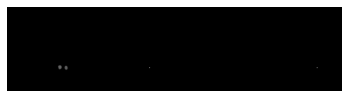

IOU: 0.0


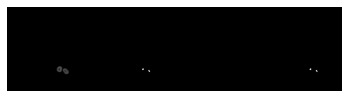

IOU: 0.0


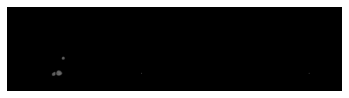

IOU: 0.0


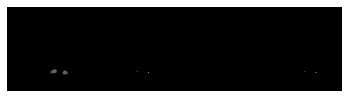

IOU: 0.0


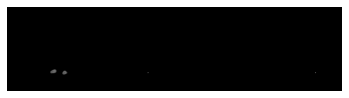

IOU: 0.0


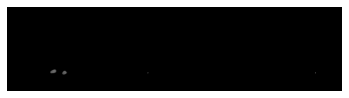

IOU: 0.0


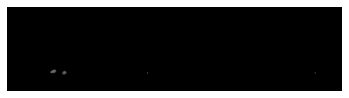

IOU: 0.0


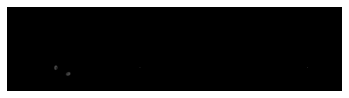

IOU: 0.0833333358168602


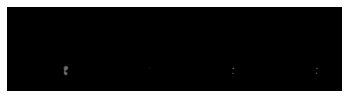

IOU: 0.06666667014360428


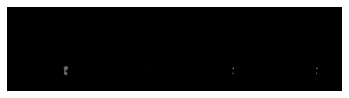

IOU: 0.0


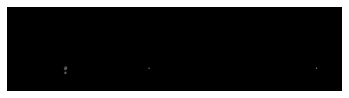

IOU: 0.0


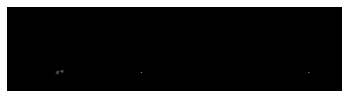

IOU: 0.0


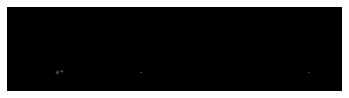

IOU: 0.0


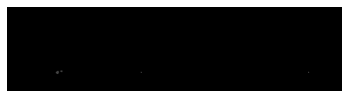

IOU: 0.0


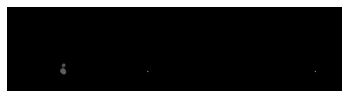

IOU: 0.0


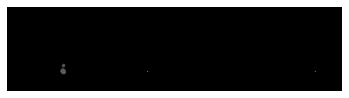

IOU: 0.0


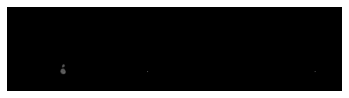

IOU: 0.0


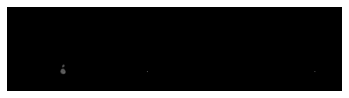

IOU: 0.0


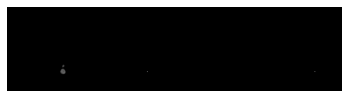

IOU: 0.0


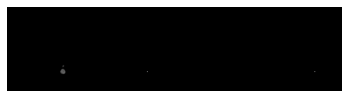

IOU: 0.0


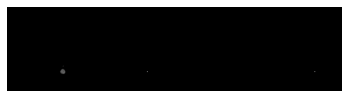

IOU: 0.0


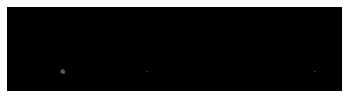

IOU: 0.0


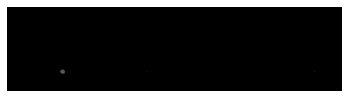

IOU: 0.0


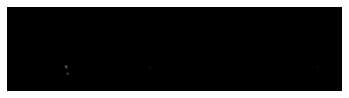

IOU: 0.0


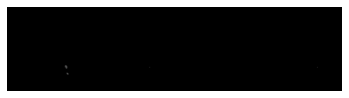

IOU: 0.0


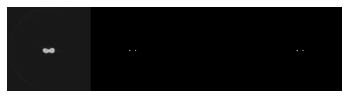

IOU: 0.0


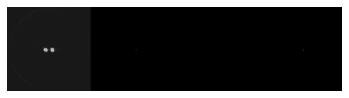

IOU: 0.0


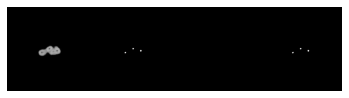

IOU: 0.0


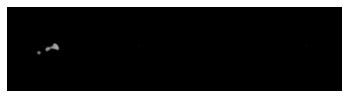

IOU: 0.0


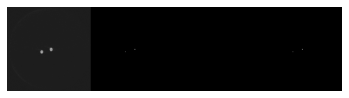

IOU: 0.0


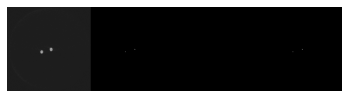

IOU: 0.0


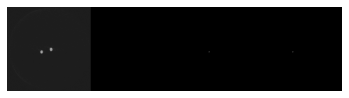

IOU: 0.0


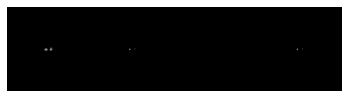

IOU: 0.0


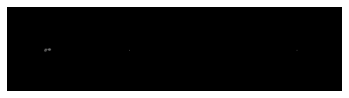

IOU: 0.0


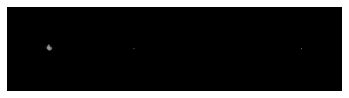

IOU: 0.0


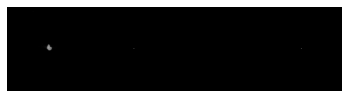

IOU: 0.0


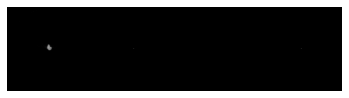

IOU: 0.0


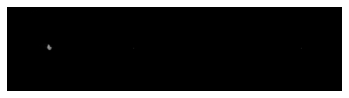

IOU: 0.0


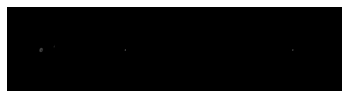

IOU: 0.0


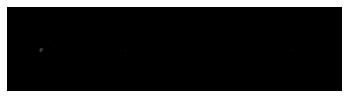

IOU: 0.0


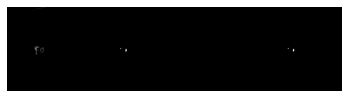

IOU: 0.0


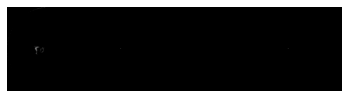

IOU: 0.0


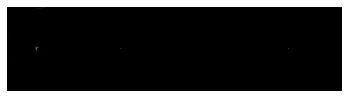

IOU: 0.0


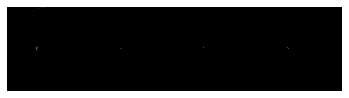

IOU: 0.0


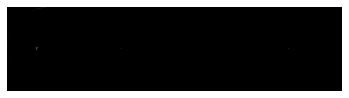

IOU: 0.0


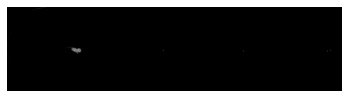

IOU: 0.0


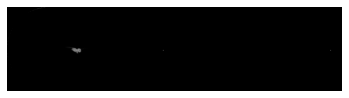

IOU: 0.0


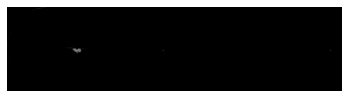

IOU: 0.0


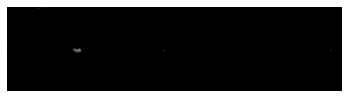

IOU: 0.0


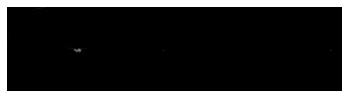

IOU: 0.0


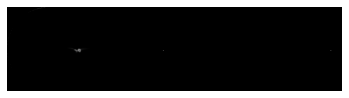

IOU: 0.0


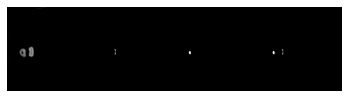

IOU: 0.0


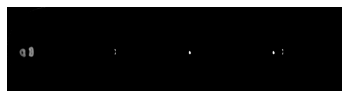

IOU: 0.06451612710952759


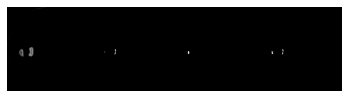

IOU: 0.0


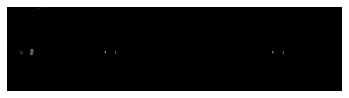

IOU: 0.0


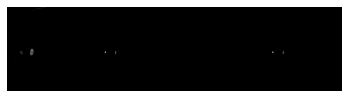

IOU: 0.0


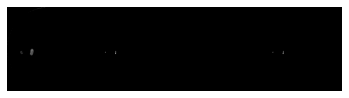

IOU: 0.0


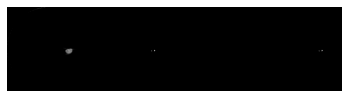

IOU: 0.0


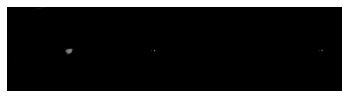

IOU: 0.0


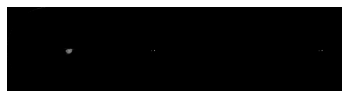

IOU: 0.0


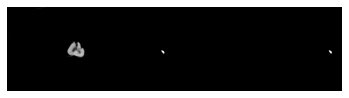

IOU: 0.0


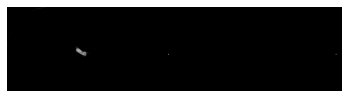

IOU: 0.0


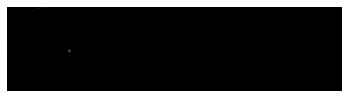

IOU: 0.0


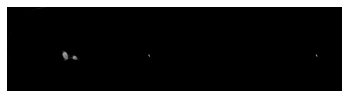

IOU: 0.0


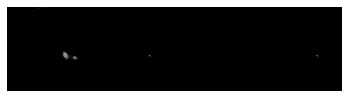

IOU: 0.0


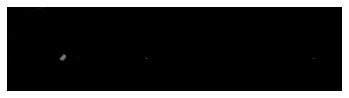

IOU: 0.0


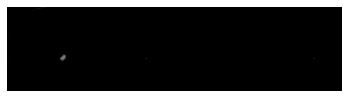

IOU: 0.0


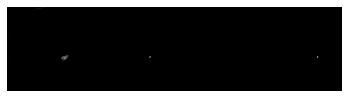

IOU: 0.0


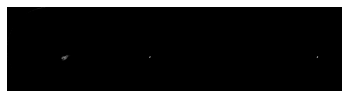

IOU: 0.0


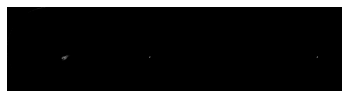

IOU: 0.0


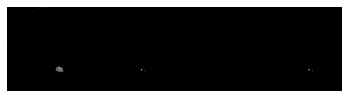

IOU: 0.0


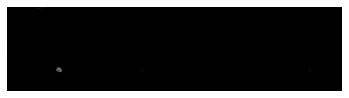

IOU: 0.0


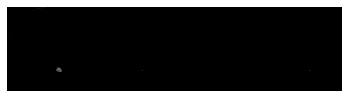

IOU: 0.0


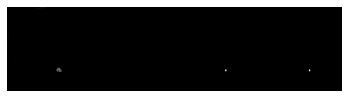

IOU: 0.0


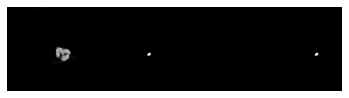

IOU: 0.0


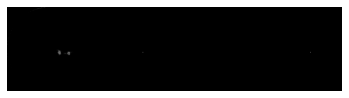

IOU: 0.0


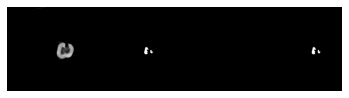

IOU: 0.0


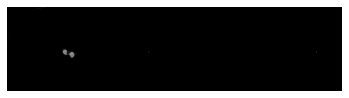

IOU: 0.0


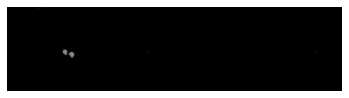

IOU: 0.0


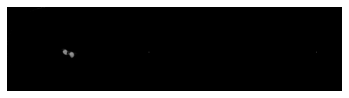

IOU: 0.0


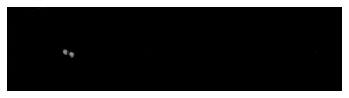

IOU: 0.0


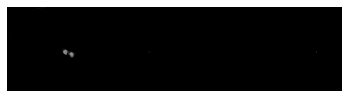

IOU: 0.0


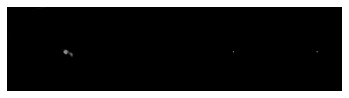

IOU: 0.0


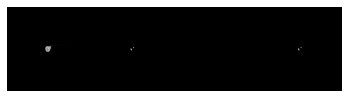

IOU: 0.0


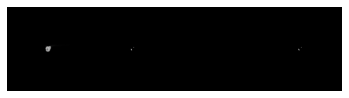

IOU: 0.0


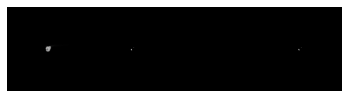

IOU: 0.0


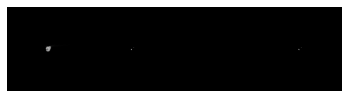

IOU: 0.0


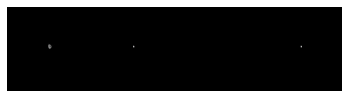

IOU: 0.0


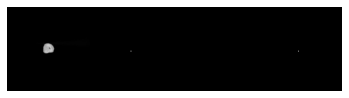

IOU: 0.0


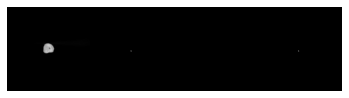

IOU: 0.0


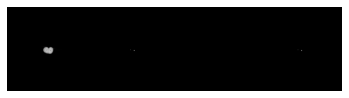

IOU: 0.0


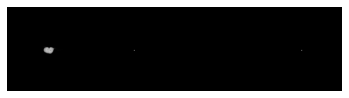

IOU: 0.0


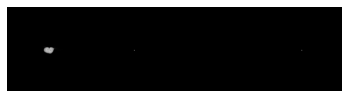

IOU: 0.0


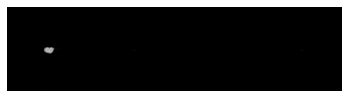

IOU: 0.0


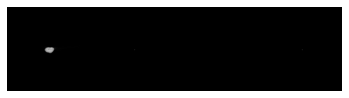

In [32]:
processImages(combined[combined.iou <= 0.1].index.values)

IOU: 1.0


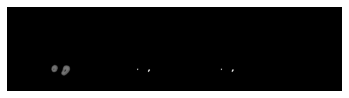

IOU: 1.0


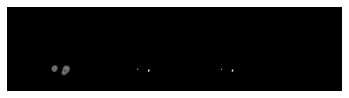

IOU: 1.0


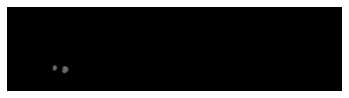

IOU: 1.0


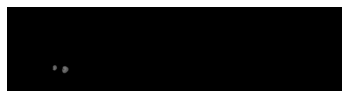

IOU: 1.0


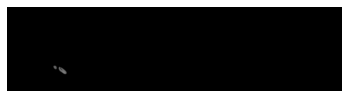

IOU: 1.0


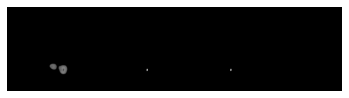

IOU: 1.0


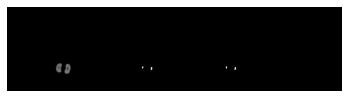

IOU: 1.0


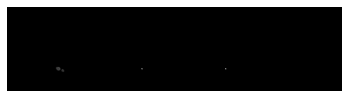

IOU: 1.0


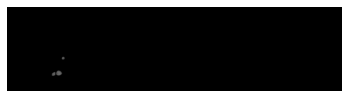

IOU: 1.0


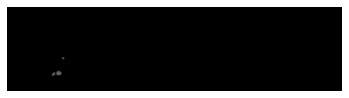

In [62]:
processImages(combined[combined.iou > 0.9999].index.values[:10])

In [36]:
avgiouPerTooth = combined.groupby("DID").agg({"iou":np.average})

In [39]:
avgiouPerTooth.columns

Index(['iou'], dtype='object')

<BarContainer object of 49 artists>

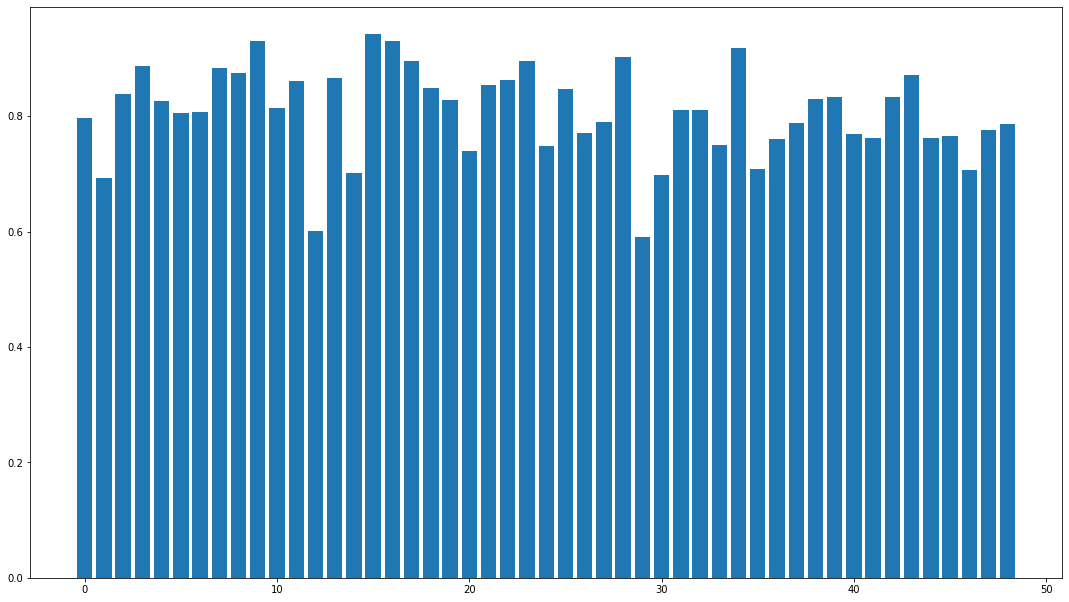

In [41]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.bar(avgiouPerTooth.index, avgiouPerTooth["iou"])
# Fogankénti átlagos IOU
# X tengely: a fog azonosítója
# Y tengely: átlagos IOU

In [56]:
combined.iou.quantile(np.linspace(0.0, 1.0, 11))
# Percentilisek, megmutatja, hogy meddig kell emelnünk az IOU felső korlátját, hogy az eredmények adott százalékát lefedjük

0.0    0.000000
0.1    0.565675
0.2    0.737705
0.3    0.812500
0.4    0.853490
0.5    0.882114
0.6    0.903452
0.7    0.923872
0.8    0.941860
0.9    0.963222
1.0    1.000000
Name: iou, dtype: float64

In [69]:
def showATeeth(did):
    ids = combined[combined.DID == did]["GID"].values
    imgPaths = [f"original/{i}.png" for i in ids]
    mskPaths = [f"roots/{i}.png" for i in ids]
    
    imgs = []
    
    for i in range(len(ids)):
        raw = Image.open(imgPaths[i])
        raw = np.array(raw.resize((256, 256)))/255.
        raw = raw[:,:,0:3]
        imgs.append(raw[:,:,0])

        truemsk = Image.open(mskPaths[i])
        truemsk = np.array(truemsk.resize((256, 256)))/255.
        if len(truemsk.shape) > 2:
            truemsk = truemsk[:,:,0]
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw, 0))

        #mask post-processing 
        msk  = pred.squeeze()
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0
        
        
    data = np.array(imgs)
    print(data.shape)
    fig = plt.figure()
    fig.set_size_inches(18.5, 10.5)
    ax = fig.gca(projection='3d')

    ax.voxels(data, alpha = 0.2)

plt.show()

# References


1.   http://deeplearning.net/tutorial/unet.html
2.   https://github.com/ldenoue/keras-unet

